In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal,Empirical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()

## Data Ingestion

In [2]:
# read training data 
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
# read test data
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
# read ground truth data
truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [5]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Preprocessing

In [6]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [8]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [9]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [10]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [11]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


## Modelling

In [13]:
# pick a large window size of 50 cycles
sequence_length = 5

In [14]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [15]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [16]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [17]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(20131, 5, 25)

In [18]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [19]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.squeeze(np.concatenate(label_gen).astype(np.float32))
label_array.shape

(20131,)

In [20]:
# target_scaler = MinMaxScaler()
# label_array = np.squeeze(target_scaler.fit_transform(label_array))
# label_array.shape

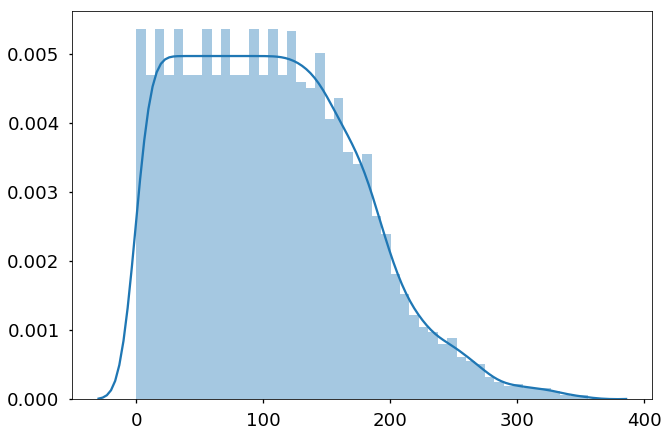

In [21]:
sns.distplot(label_array)

In [22]:
seq_array1,seq_array2,label_array1,label_array2 = train_test_split(seq_array,label_array,test_size=0.1,shuffle=False)

In [23]:
H = 100  # number of hidden units
N,_,D = seq_array1.shape  # number of training data points, number of features
H,N,sequence_length,D

(100, 18117, 5, 25)

## FC
------------------------

In [24]:
def neural_network_with_2_layers(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

dim = 10  # layer dimensions

W_0 = Normal(loc=tf.zeros([D, dim]),
             scale=tf.ones([D, dim]))
W_1 = Normal(loc=tf.zeros([dim, 1]),
             scale=tf.ones([dim, 1]))
b_0 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_2_layers(x, W_0, W_1, b_0, b_1),
           scale=tf.ones(N) * 0.1)  # constant noise

In [25]:
# BACKWARD MODEL A
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([dim, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [26]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1},
                    data={x: seq_array1[:,sequence_length-1,:], y: label_array1})
inference.run(n_samples=5,n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 273s | Loss: 1343240832.000


In [27]:
xp = tf.placeholder(tf.float32,seq_array2[:,sequence_length-1,:].shape)

In [28]:
y_pred = sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})

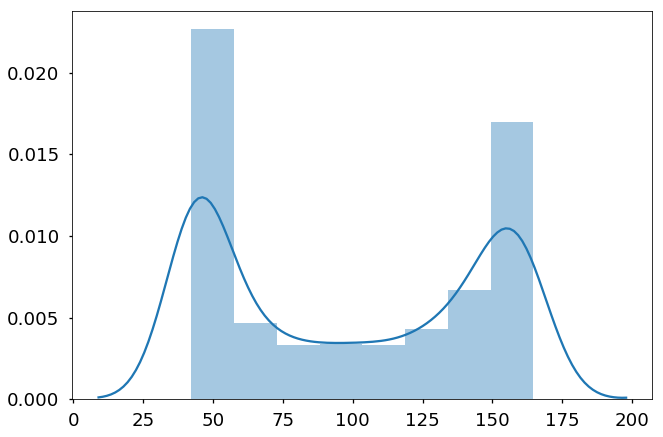

In [29]:
sns.distplot(y_pred)

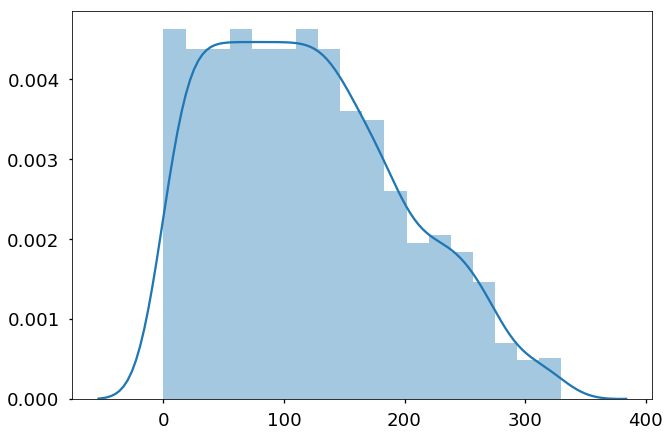

In [30]:
sns.distplot(label_array2)

In [31]:
np.sqrt(mean_squared_error(label_array2,y_pred))

58.029888

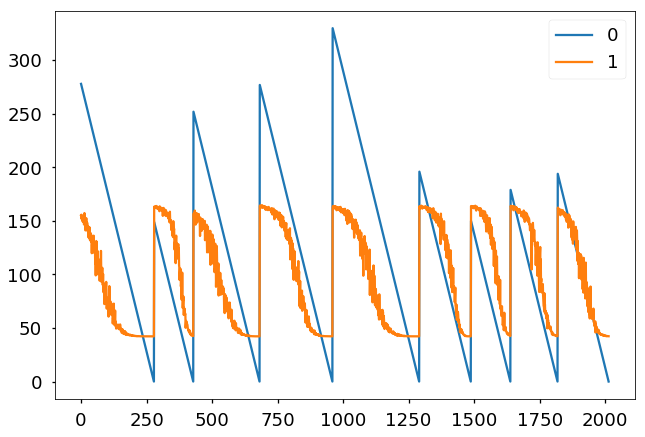

In [32]:
pd.DataFrame([label_array2,y_pred]).transpose().plot()

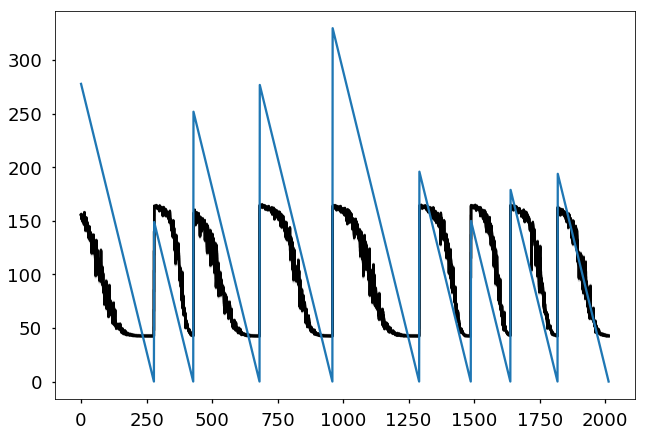

In [33]:
[plt.plot(sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]}),
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2)

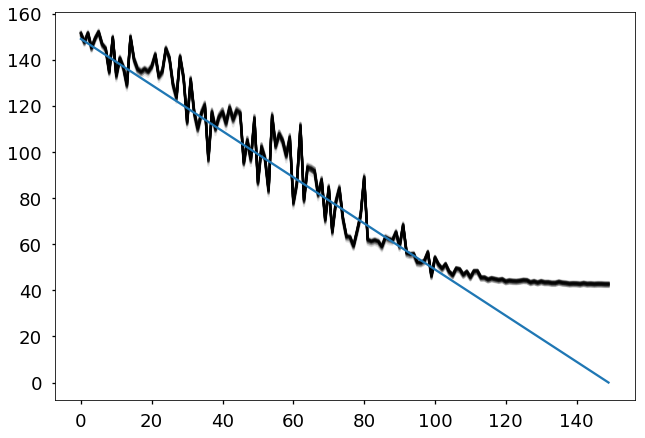

In [34]:
[plt.plot(sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])

## RNN
-------------------

In [35]:
def rnn_cell_sig(hprev, xt, Wh, Wx, bh):
    return tf.sigmoid(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def rnn_cell_tanh(hprev, xt, Wh, Wx, bh):
    return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

In [36]:
def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = rnn_cell_tanh(h,tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wh, Wx, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])

# def rnn_cell(hprev, xt):
#     return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

# def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
#     sequence_length, N, D = X.get_shape().as_list()
#     h = tf.scan(rnn_cell, X, initializer=tf.truncated_normal([N,H],mean=0.,stddev=0.1))
#     h = tf.squeeze(tf.slice(h,[sequence_length-1,0,0],[1,N,H]))
#     y = tf.reshape(tf.nn.softplus(tf.matmul(h, Wy) + by),[-1])
#     return y

Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Wx = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
# X = tf.placeholder(tf.float32,[sequence_length,N,D])
y = Normal(loc=rnn_layer(X, Wh, Wx, bh, Wy, by, H), scale=1.)

## BBVI

In [37]:
# BACKWARD MODEL A
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Wx = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [38]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wh: q_Wh, bh: q_bh,
                                 Wx: q_Wx, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 1686s | Loss: 10966126.000


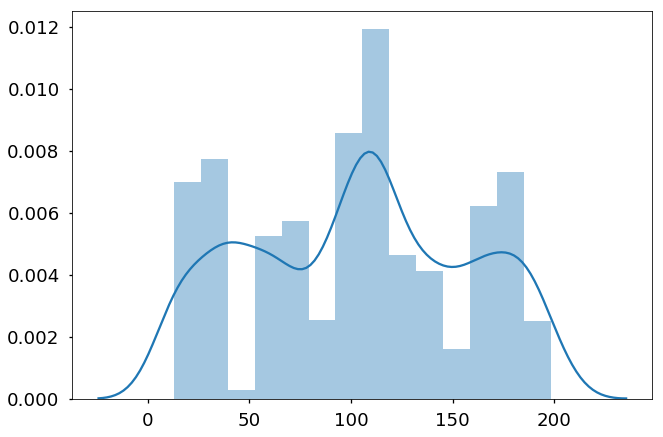

In [39]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [40]:
np.sqrt(mean_squared_error(label_array2,y_pred))

53.499355

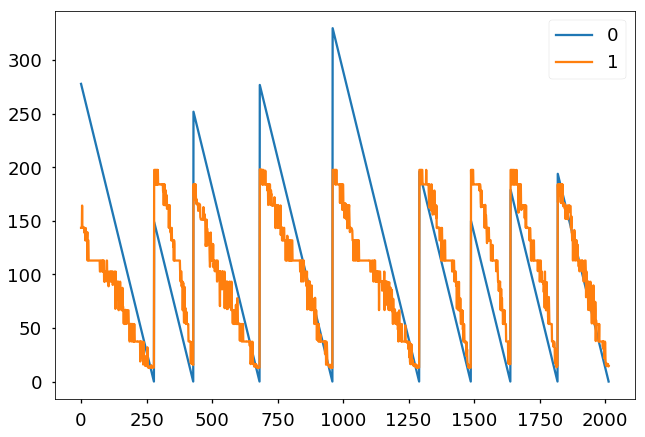

In [41]:
pd.DataFrame([label_array2,y_pred]).transpose().plot()

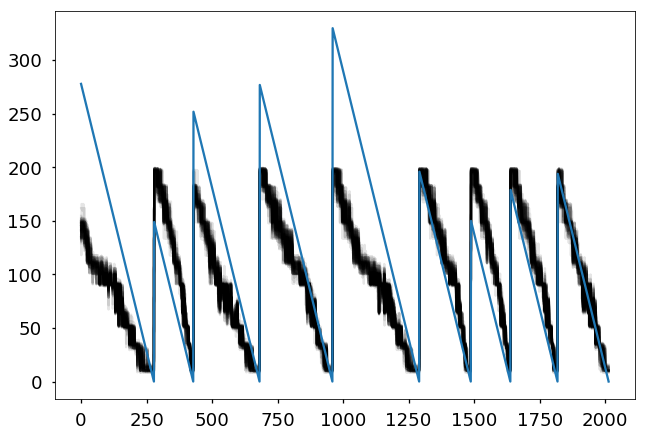

In [42]:
[plt.plot(sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2}),
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2)

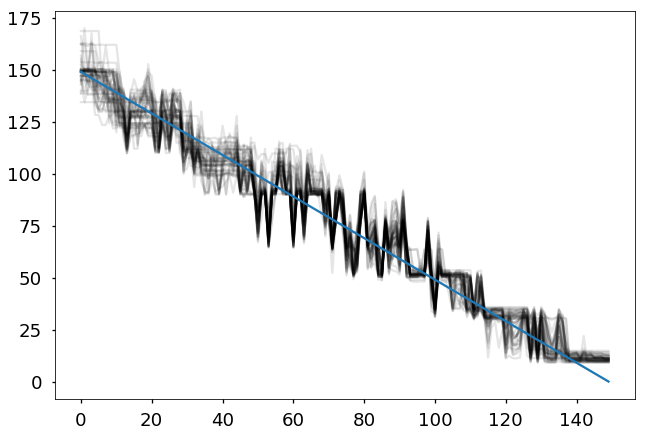

In [43]:
[plt.plot(sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])

## LSTM
-----------------

In [44]:
def LSTM_cell(hprev, cprev, xt, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc):
    f = rnn_cell_sig(hprev,xt,Wf,Uf,bf)
    i = rnn_cell_sig(hprev,xt,Wi,Ui,bi)
    o = rnn_cell_sig(hprev,xt,Wo,Uo,bo)
    c = f*cprev + i*rnn_cell_tanh(hprev,xt,Wc,Uc,bc)
    h = o*tf.tanh(c)
    return h,c

def LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    c = tf.zeros([N,H])
    for i in range(sequence_length):
        h,c = LSTM_cell(h, c, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wf = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uf = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wi = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ui = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wo = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uo = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wc = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uc = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bf = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bi = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bo = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bc = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H), scale=1.)

## BBVI

In [45]:
# BACKWARD MODEL A
q_Wf = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uf = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wi = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ui = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wo = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uo = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wc = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uc = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bf = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bi = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bo = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bc = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [46]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf: q_Wf, Uf: q_Uf, Wi: q_Wi, Ui: q_Ui, Wo: q_Wo, Uo: q_Uo, Wc: q_Wc, Uc: q_Uc,
                                 bf: q_bf, bi: q_bi, bo: q_bo, bc: q_bc, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 8135s | Loss: 9734269.000


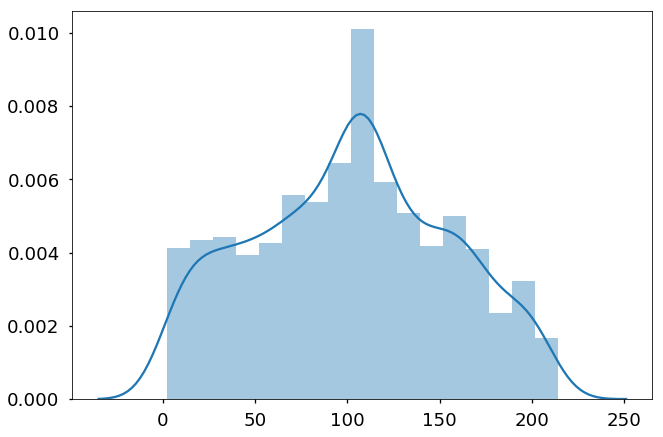

In [47]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [48]:
np.sqrt(mean_squared_error(label_array2,y_pred))

52.319683

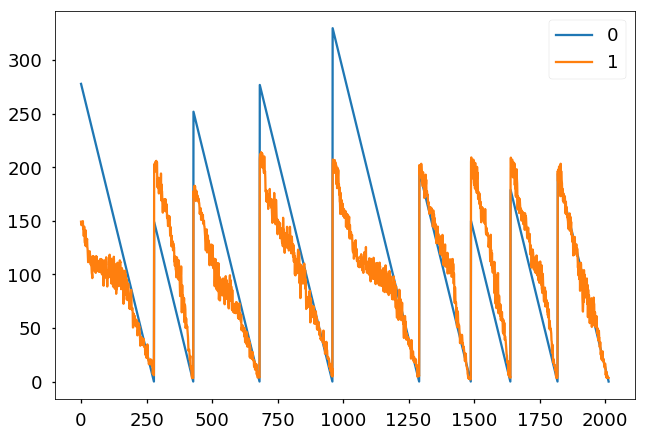

In [49]:
pd.DataFrame([label_array2,y_pred]).transpose().plot()

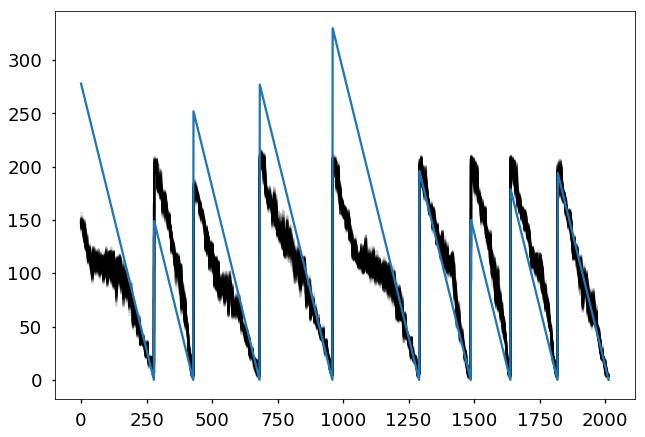

In [50]:
[plt.plot(sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2}),
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2)

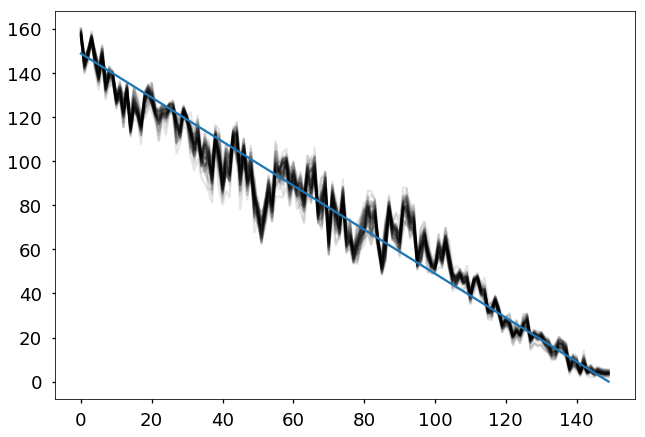

In [51]:
[plt.plot(sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])

## GRU
-----------------

In [52]:
def GRU_cell(hprev, xt, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh):
    z = rnn_cell_sig(hprev,xt,Wz,Uz,bz)
    r = rnn_cell_sig(hprev,xt,Wr,Ur,br)
    h = z*hprev + (1-z)*rnn_cell_tanh(r*hprev,xt,Wh,Uh,bh)
    return h

def GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = GRU_cell(h, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wz = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uz = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wr = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ur = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uh = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bz = Normal(loc=tf.zeros(H), scale=tf.ones(H))
br = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H), scale=1.)

## BBVI

In [53]:
# BACKWARD MODEL A
q_Wz = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uz = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wr = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ur = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uh = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bz = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_br = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [54]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wz: q_Wz, Uz: q_Uz, Wr: q_Wr, Ur: q_Ur, Wh: q_Wh, Uh: q_Uh,
                                 bz: q_bz, bz: q_bz, bh: q_bh, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 6414s | Loss: 9761533.000


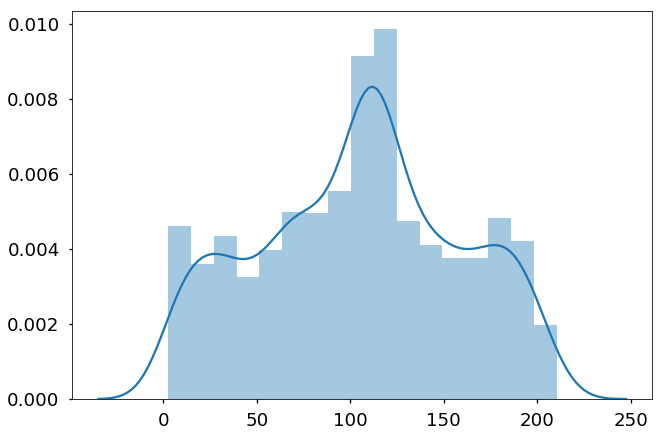

In [55]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
sns.distplot(y_pred)

In [56]:
np.sqrt(mean_squared_error(label_array2,y_pred))

52.11134

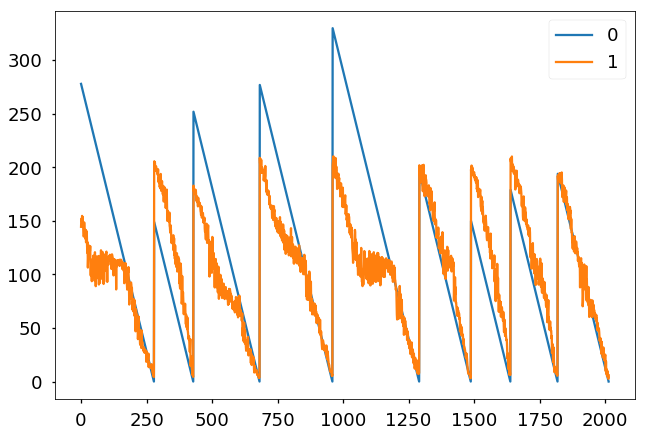

In [57]:
pd.DataFrame([label_array2,y_pred]).transpose().plot()

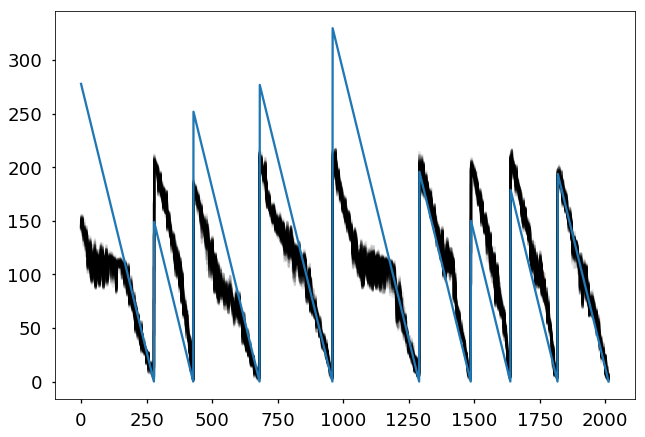

In [58]:
[plt.plot(sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2}),
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2)

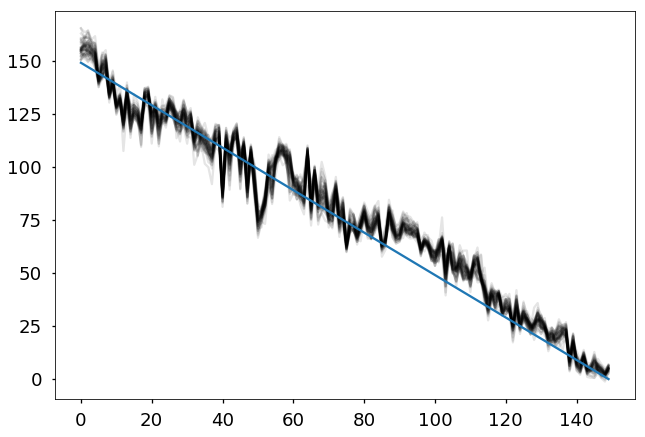

In [59]:
[plt.plot(sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})[-150:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-150:])